In [1]:
#hide
import sys
import numpy as np
from numpy import linalg as la
import matplotlib
from matplotlib import animation, pyplot as plt
import proplot as plot
import seaborn as sns
from scipy.fft import fft2, ifft2

sys.path.append('/Users/46h/Research/code/accphys/')
from tools import (
    plotting as myplt,
    animation as myanim,
    utils
)
plt.rcParams['animation.html'] = 'jshtml'
plot.rc['figure.facecolor'] = 'white'
plot.rc['savefig.dpi'] = 'figure'

# Particle-in-cell simulation
> An introduction to electrostatic PIC solvers

- toc: true 
- badges: false
- comments: true
- categories: [physics, accelerators, simulation]
- image: images/chart-preview.png

In my research I utilize [PyORBIT](link), one of many particle-in-cell (PIC) simulation codes for particle accelerators. These codes track a beam of particles though the time-varying electromagnetic fields provided by an accelerator; we call this *external focusing*. In addition to external focusing, there are also *internal* forces to consider caused by the electromagnetic interactions between the beam particles. These are known as *space charge* forces, which refers to the charge density of the beam in free space. This post introduces the problem of understanding the effects of space charge through computer simulation by building a simple simulation engine in Python. Links to relevant books, lectures, and programs are included at the end; I am basically restating parts of these works. I just always find that I understand things better after writing them down.

## Theoretical model 

We'll use *bunch* to refer to a group of particles in three-dimensionl (3D) space; usually a beam is composed of multiple bunches. We want to track a single bunch. We will use a local cartesian coordinate system whose origin is at the center of the bunch as shown below:

<img src='images_2021-02-15/coordinate_system.png' width=500>

The $s$ coordinate specifies the position of the bunch in the accelerator. Now for the simplifying assumptions. First, we will assume the beam is in free space, so there are no external fields. Second, we will assume the center of the bunch is moving at a constant velocity $\beta c$, where $c$ is the speed of light. In this way we can eliminate the time variable in favor of the $s$ variable by $s = \beta c t$. We can then write $z = s - \beta ct$. Third, we will assume there is no energy spread in the bunch, meaning all the particles move at this velocity. Third, we will ignore the dynamics in the $z$ direction, assuming the bunch has a uniform charge density in this dimension and is infinitely long. We will just look at the motion in a thin transverse ($x$-$y$) slice of the bunch. Fourth, we neglect any magnetic fields generated by the beam. This being said, the equations of motion can be written as 

$$ \mathbf{x}'' = \frac{q}{mc^2\beta^2\gamma^3} \mathbf{E}, \tag{1}$$

where $\mathbf{x}$ is the coordinate vector, $\mathbf{E}$ is the electric field, $\gamma = \sqrt{1 - \beta^2}$, and the prime means differentiation with respect to $s$. 

Let's first address the factor $\gamma^{-3}$ in the equation of motion. This means the space charge force goes to zero as the velocity approaches the speed of light. A simple example which illustrates this is to consider two parallel charges moving at speed $\beta_c$ in the lab frame. Of course there is an electrical repulsion between the charges, but we must also remember that a moving charge creates a *magnetic field* which tries to pull the charges together. This reduces the strength of the electric repulsion between the charges, completely cancelling it at the speed of light. One may ask: what about the rest frame? In this frame the magnetic attraction is zero and the particles repel each other. Well, true. But special relativity says that the electrogmagnetic fields change when we switch our reference frame. Using the transformations defined [here](https://en.wikipedia.org/wiki/Classical_electromagnetism_and_special_relativity), you can quickly prove that 

$$\mathbf{E}_{lab} = \frac{\mathbf{E}_{rest}}{\gamma}. \tag{2}$$

As usual for relativity, the math is simple but the interpretation is difficult. It has to do with the [time dilation](https://en.wikipedia.org/wiki/Time_dilation) which occurs when we transform back to the lab frame. This post is not about relativity, so we'll stop the discussion here. It is an important point to mention, however, because it has real-life consequences. It tells us that space charge is important if 1) the beam is very intense, meaning there are many particles in a small area, or 2) the beam is very energetic, meaning it is moving extremely fast. For example, space charge can usually be ignored in electron beams, which move near the speed of light for very modest energies due to their tiny mass, but is significant in high-intensity, low-energy hadron accelerators such as [FRIB](https://frib.msu.edu), [SNS](https://neutrons.ornl.gov/sns), and [ESS](https://europeanspallationsource.se).

Now we should address the difficulty in determining the evolution of this system: the force on a particle in an $n$-particle bunch depends on the positions of the other $n - 1$ particles in the beam. One approach is to introduce a [distribution function](https://en.wikipedia.org/wiki/Distribution_function_(physics)) $f(\mathbf{x}, \mathbf{v}, t)$ which gives the number of particles in an infinitesimal volume of phase space. The Vlasov-Poisson system of equations determines the evolution of $f$ (as long as we ignore collisions between particles and any magnetic fields):

$$\frac{\partial{f}}{\partial{s}} + \mathbf{x}'\cdot \frac{\partial{f}}{\partial{\mathbf{x}}} + \frac{q}{mc^2\beta^2\gamma^3} \mathbf{E} \cdot \frac{\partial{f}}{\partial{\mathbf{x}'}}. \tag{3}$$

The electric field is obtained from the Poisson equation:

$$ \nabla \cdot \mathbf{E} = -\nabla^2 \phi = \frac{\rho}{\varepsilon_0}. \tag{4}$$

Finally, the charge density $\rho$ is determined by integrating the velocity components out of the distribution function:

$$\rho = q \int{f dx'dy'}. \tag{5}$$

Although these equations are easy to write down, they are generally impossible to solve analytically.

## Computational method

We need to turn to a computer for help. We could try to solve the Vlasov equation directly, but this is very difficult. Alternativly, we could track track each individual particle, computing the forces using direct sums, i.e., the force on particle $i$ would be given by $\sum_{j \ne i}^{n} \mathbf{F}_{ji}$. But this is infeasible with current hardware; the number of particles in the bunch may be on the order of $10^{14}$. How can we get around this? 

In comes the particle-in-cell (PIC) method. It is sort of a combination of the above these two approaches. The idea is to track a group of *macroparticles*, each of which represents a large number of real particles, according to Eq. (1). When calculating the field, however, we will assume a continuous charge density and solve the Poisson equation on a discretized grid. We then reverse the process to obtain the electric field at each macroparticle location, and finally update its position. This cycle is shown below.

<img src='images_2021-02-15/picloop.png' width=500>

In the next sections I will discuss each of these steps. Let's first create a `Bunch` class.

In [2]:
class MacroParticle:
    """Container for macroparticles."""
    def __init__(self, coords=None, size=1, index=None):
        self.coords = coords
        self.x, self.xp, self.y, self.yp = coords
        self.size = size # number of physical particles represented
        self.id = index

In [3]:
#hide
# 79 characters:
###############################################################################

In [4]:
class Bunch:
    """Container for distribution of particles in transverse phase space.
    
    The particles in this 2D model are uniform density line charges of infinite
    length. The default attributes are set to describe a typical bunch in the 
    Spallation Neutron Source (SNS) proton accumulator ring.
    
    TO DO: perveance calculation.
    
    Attributes
    ----------
    nparts : float
        Number of macroparticles in the bunch.
    mass : float
        Particle mass [MeV/c^2].
    kin_energy : float
        Kinetic energy per particle [MeV].
    charge : float
        Charge per particle in units of elementary charge.
    line_density : float
        Density in the longitudinal direction. 
    intensity : float
        Number of physical particles in the bunch. Default: 1e14.
    macrosize : float
        Number of physical particles represented by each macroparticle.
    perveance : float
        The dimensionless space charge perveance.
    X : ndarray, shape (nparts, 4)
        The bunch coordinate array. Columns are [x, x', y, y']. Units are mm 
        and mrad.
    positions : ndarray, shape (nparts, 2):
        Only the x and y positions (for convenience).
    particles : list[MacroParticle]
        A list of MacroParticle objects.
    """
    def __init__(self, nparts=1, mass=938, kin_energy=1000, charge=1, 
                 line_density=4e11, intensity=1e14):
        self.nparts = int(nparts)
        self.mass = mass
        self.kin_energy = kin_energy
        self.charge = charge
        self.line_density = line_density
        self.X = None
        self.positions = None
        self.particles = None
        self.macrosize = intensity / nparts

    def generate(self, kind='gaussian'):
        """Generate a distribution."""
        if kind == 'gaussian':
            self.X = np.random.normal(size=(self.nparts, 4))
        elif kind == 'kv':
            self.X = np.random.normal(size=(self.nparts, 4))
            self.X = np.apply_along_axis(lambda x: x/la.norm(x), 1, self.X)
        self.positions = self.X[:, [0, 2]]
        self.particles = [MacroParticle(coords, self.macrosize) 
                          for coords in self.X]
        self.compute_extremum()
    
    def compute_extremum(self):
        """Get extreme x and y coorinates."""
        self.xmin, self.ymin = np.min(self.positions, axis=0)
        self.xmax, self.ymax = np.max(self.positions, axis=0)
        self.xlim, self.ylim = (self.xmin, self.xmax), (self.ymin, self.ymax)
        
    def sample(self, k):
        """Return random sample of k particles."""
        if k >= self.nparts:
            return self.X
        X_samp = np.copy(self.X)
        idx = np.random.choice(self.nparts, k, replace=False)
        return X_samp[idx, :]

### Weighting 

Starting from a group of macroparticles, we need to produce a charge density $\rho_{ij}$ on the grid. The most simple approach is the *nearest grid point (NGP)* method, in which each particle is assigned to the closes grid point (in both dimensions). This is commonly called *zero-order weighting*; it is very fast and easy to implement (we are just creating a 2D histogram), but can lead to significant noise.

A better method called *cloud-in-cell (CIC)* treats each macroparticle as a rectangular, uniform density cloud of charge with dimensions determined by the grid spacing. A fraction of the total charge is assigned based on the fraction of the cloud overlapping with a given cell. This can be thought of as *first-order weighting*. There are also higher order methods, but these are more expensive and I don't include them here.

To get a sense of what these methods are doing (in 1D), we can slide a particle across a cell and plot the resulting density of the cell at each position, thus giving an effective shape to the macroparticle.

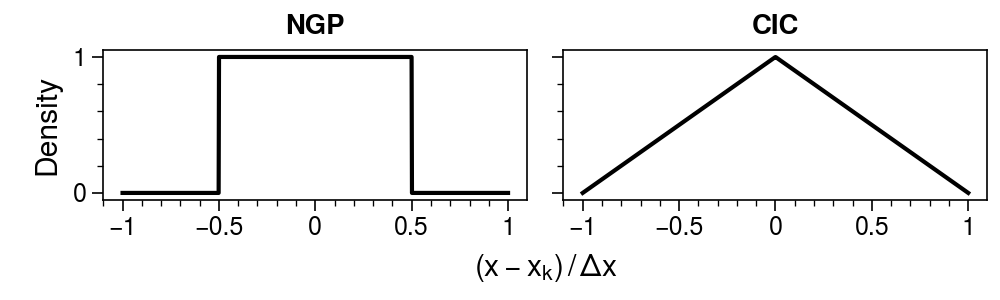

In [5]:
#hide_input
def shape_func(u, v, cell_width, method='ngp'):
    S, diff = 0, np.abs(u - v)
    if method == 'ngp':
        S = 1 if diff < (0.5 * cell_width) else 0
    elif method == 'cic':
        S = 1 - diff/cell_width if diff < cell_width else 0
    return S / cell_width

fig, axes = plot.subplots(ncols=2, figsize=(5, 1.5))
xvals = np.linspace(-1, 1, 1000)
for ax, method in zip(axes, ['ngp', 'cic']):
    densities = [shape_func(x, 0, 1, method) for x in xvals]
    ax.plot(xvals, densities, 'k')
axes.format(xlabel='($x - x_k) \,/\, \Delta x$', ylabel='Density', grid=False, 
            xlabel_kw={'size':'large'}, ylabel_kw={'size':'large'}, 
            toplabels=['NGP', 'CIC'])

We see that the NGP method leads to a discontinuous boundary, while the CIC method leads to a continous boundary (but discontinous derivative). Higher order methods will lead to a completely smooth boundary. The following `Grid` class implements these weighting methods.

In [6]:
class Grid:
    """Class for 2D grid. 
    
    The grid data is stored as a 2D array.
    
    Attributes
    ----------
    xmin, ymin, xmax, ymax : float
        Minimum and maximum coordinates.
    Nx, Ny : int
        Number of grid points.
    dx, dy : int
        Spacing between grid points.
    x, y : ndarray, shape (Nx,) or (Ny,)
        Positions of each grid point.
    """
    def __init__(self, xlim=(-1, 1), ylim=(-1, 1), size=(128, 128)):
        self.xlim, self.ylim = xlim, ylim
        self.xmin, self.xmax = xlim
        self.ymin, self.ymax = ylim
        if type(size) is int:
            size = (size, size)
        self.size = size
        self.Nx, self.Ny = self.size
        self.dx = (self.xmax - self.xmin) / (self.Nx - 1)
        self.dy = (self.ymax - self.ymin) / (self.Ny - 1)
        self.cell_area = self.dx * self.dy
        self.x = np.linspace(self.xmin, self.xmax, self.Nx)
        self.y = np.linspace(self.ymin, self.ymax, self.Ny)
        
    def zeros(self):
        return np.zeros((self.size))
        
    def get_nearest_indices(self, positions):
        """Get indices nearest to each point.
        
        Parameters
        ----------
        positions: ndarray, shape (n, 2)
            List of (x, y) positions.
            
        Returns
        -------
        ndarray, shape (n, 2)
            List of (i, j) indices of nearest grid points.
        """
        ivals = np.round((positions[:, 0] - self.xmin) / self.dx).astype(int)
        jvals = np.round((positions[:, 1] - self.ymin) / self.dy).astype(int)
        return np.vstack([ivals, jvals]).T
    
    def distribute(self, positions, method='cic'):
        """Compute density on grid.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
        method : {'ngp', 'cic'}
            * 'ngp': nearest grid point
            * 'cic': cloud-in-cell: 
            
        Returns
        -------
        rho : ndarray, shape (Nx, Ny)
            Density at each grid point.
        """
        if method not in ['ngp', 'cic']:
            print("Invalid method. Options: {'ngp', 'cic'}")
            return
        
        rho = self.zeros()
                    
        if method == 'ngp':
            xrange = (self.xmin - self.dx/2, self.xmax + self.dx/2)
            yrange = (self.ymin - self.dy/2, self.ymax + self.dy/2)
            x, y = positions.T
            rho, _, _ = np.histogram2d(x, y, bins=[self.Nx, self.Ny], 
                                               range=(xrange, yrange))
        elif method == 'cic':
            nearest_indices = self.get_nearest_indices(positions)
            for (x, y), (i, j) in zip(positions, nearest_indices):
                if i < self.Nx - 1 and j < self.Ny - 1:
                    A1 = (x - self.x[i]) * (y - self.y[j])
                    A2 = (self.x[i + 1] - x) * (y - self.y[j])
                    A3 = (x - self.x[i]) * (self.y[j + 1] - y)
                    A4 = (self.x[i + 1] - x) * (self.y[j + 1] - y)
                    rho[i, j] += A4
                    rho[i + 1, j] += A3
                    rho[i, j + 1] += A2
                    rho[i + 1, j + 1] += A1
            rho /= self.cell_area
        return rho
    
    def compute_gradient(self, grid_vals):
        """Return x and y derivatives of the grid vals using 2nd order centered differencing."""
        return np.gradient(grid_vals)
    
    def interpolate(self, positions, grid_vals, method='cic'):
        """Interpolate vals at each position.
        
        Parameters
        ----------
        positions : ndarray, shape (n, 2)
            List of (x, y) positions.
        grid_vals : ndarray, shape (Nx, Ny)
            Scalar value at each grid point.
        method : {'ngp', 'cic'}
            * 'ngp': nearest grid point
            * 'cic': cloud-in-cell
            
        Returns
        -------
        int_vals : ndarray, shape (nparts,)
            Interpolated value at each position.
        """
        if method not in ['ngp', 'cic']:
            print("Invalid method. Options: {'ngp', 'cic'}")
            return
        
        int_vals = []
        nearest_indices = self.get_nearest_indices(positions)
        if method == 'ngp':
            for (x, y), (i, j) in zip(positions, nearest_indices):
                int_vals.append(grid_vals[i, j])
            int_vals = np.array(int_vals)
        if method == 'cic':
            for (x, y), (i, j) in zip(positions, nearest_indices):
                A1 = A2 = A3 = A4 = 0.
                if i < grid.Nx - 1 and j < grid.Ny - 1:
                    A1 = (part.x - grid.x[i]) * (part.y - grid.y[j])
                    A2 = (grid.x[i + 1] - part.x) * (part.y - grid.y[j])
                    A3 = (part.x - grid.x[i]) * (grid.y[j + 1] - part.y)
                    A4 = (grid.x[i + 1] - part.x) * (grid.y[j + 1] - part.y)
                int_value = A4 * grid_vals[i, j]     \
                          + A3 * grid_vals[i + 1, j] \
                          + A2 * grid_vals[i, j + 1] \
                          + A1 * grid_vals[i + 1, j + 1]
                int_vals.append(int_value)
            int_vals = np.array(int_vals) / grid.cell_area
        return int_vals

It should be mentioned that the field interpolation method should be the same as the charge deposition method; if this is not true, it is possible for a particle to exert a force on itself! To test out these methods, we consider a gaussian distribution of 1,000,000 macroparticles in the $x$-$y$ plane. We'll choose the number of grid points to be $N_x = N_y = 128$.

In [8]:
bunch = Bunch(nparts=int(100000))
bunch.generate('gaussian')
grid = Grid(bunch.xlim, bunch.ylim, size=(64, 64))

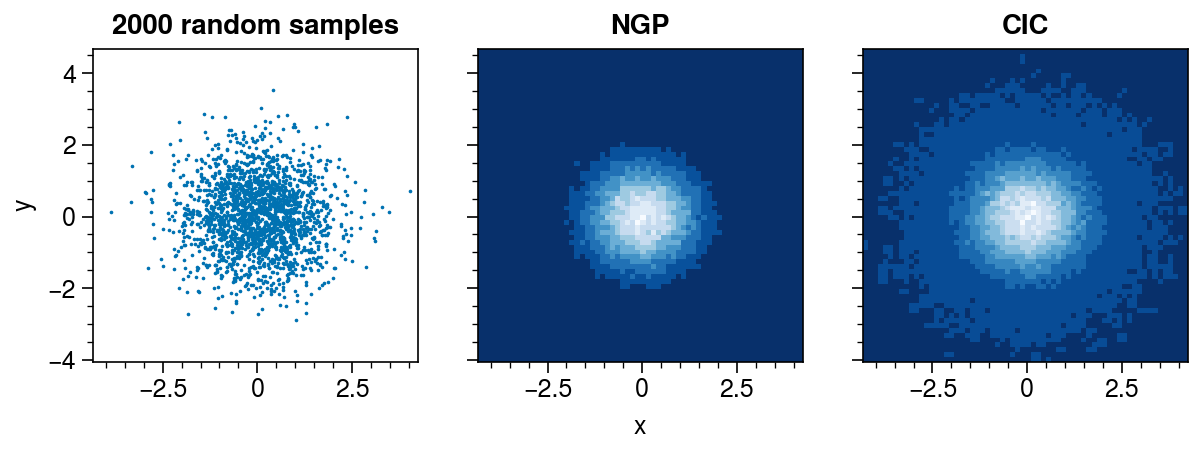

In [9]:
fig, axes = plot.subplots(ncols=3, figsize=(6, 2.25), wspace=2*[0.3])
axes.format(xlim=bunch.xlim, ylim=bunch.ylim, grid=False, xlabel='x', ylabel='y', 
            toplabels=['2000 random samples', 'NGP', 'CIC'])

X = bunch.sample(2000)
axes[0].scatter(X[:, 0], X[:, 2], s=0.5)

for ax, method in zip(axes[1:], ['ngp', 'cic']):
    rho = grid.distribute(bunch.positions, method)
    ax.imshow(rho.T, origin='lower', cmap='blues_r', aspect='auto', 
              extent=[grid.xmin, grid.xmax, grid.ymin, grid.ymax]);

### Field solver 

The workhorse in the simulation loop is the field solver. We need to solve Poisson's equation:

$$\left({\frac{\partial^2}{dx^2} + \frac{\partial^2}{dy^2}}\right) = -\frac{\rho\left(x, y\right)}{\varepsilon_0}. \tag{6}$$

The discretized version of the equation reads

$$ \frac{\phi_{i+1,j} + -2\phi_{i,j} +\phi_{i-1,j}}{(\Delta x)^2} + \frac{\phi_{i,j+1} + -2\phi_{i,j} + \phi_{i,j-1}}{(\Delta y)^2} = -\frac{\rho_{i,j}}{\varepsilon_0} \tag{7}$$

There are multiple paths to a solution; we will focus on the method implemented in PyORBIT, which utilizes the Fourier convolution theorem. 

#### Green's functions and convolution theorem

Let's write the potential of a single infinite line charge at radius, with charge density $\lambda$, as a function of $r = (x^2 + y^2)^{1/2}$:

$$ \phi(\mathbf{x}) = -\frac{\lambda}{2\pi\varepsilon_0} \ln{|\mathbf{x}|} = -\frac{\lambda}{2\pi\varepsilon_0} \int{\ln{|\mathbf{x} - \mathbf{q}|}\delta(\mathbf{q})d\mathbf{q}}. \tag{8}$$

Note that $\mathbf{q}$ is just a dummy variable; usually a prime is used, but we already assigned physical meaning to $\mathbf{x}'$. By defining $G(\mathbf{x} - \mathbf{q}) = -\frac{\lambda}{2\pi\varepsilon_0} \ln{|\mathbf{x} - \mathbf{q}|}$ and $\rho(\mathbf{x}) = \delta(\mathbf{x})$, we have

$$ \phi(r) = \int{G(\mathbf{x} - \mathbf{q})\rho(\mathbf{q})d\mathbf{q}} = G(\mathbf{x}) * \rho(\mathbf{x}). \tag{9}$$

In this form the potential is a [convolution](https://en.wikipedia.org/wiki/Convolution) (represented by $*$) of the transverse charge density $\rho$ with $G$, which is called the [Green's function](https://en.wikipedia.org/wiki/Green%27s_function). Basically, this just says that the total potential will be the sum of the potential of each individual charge, which is given by $G$. On the grid this will look like

$$ \phi_{i, j} = \sum_{k,l \ne i,j}{G_{i-k, j-l} \rho_{k, l}}. \tag{11}$$

This convolution has $O(N^2)$ time complexity, where $N$ is the number of grid points; however, we can exploit the [convolution theorem](https://en.wikipedia.org/wiki/Convolution_theorem) to speed things up, which says that the Fourier transform of a convolution of two functions is equal to the product of their Fourier transforms. The Fourier transform is defined by

$$\hat{\phi}(\mathbf{k})= \mathcal{F}\left[\phi(\mathbf{x})\right] = \int_{-\infty}^{\infty}{e^{-\mathbf{k}\cdot\mathbf{x}} \phi(\mathbf{x}) d\mathbf{x}}. \tag{12}$$

The convolution theorem then says:
$$\mathcal{F}\left[\phi * G\right] = \mathcal{F}\left[\phi\right] \cdot \mathcal{F}\left[G\right]. \tag{13}$$

The dot represents the pointwise product. For the discrete equation this gives

$$\hat{\phi}_{n, m} = \hat{\rho}_{n, m} \hat{G}_{n, m}, \tag{14}$$

where the hat represents the [discrete Fourier transform](https://en.wikipedia.org/wiki/Discrete_Fourier_transform) (DFT). With the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) algorithm at our disposal, the time complexity can be reduced to $O\left(N \log N\right)$.

#### Implementation

There is a caveat to this method: to use the FFT algorithm, Eq. (11) must be a circular convolution, which means $G$ must be periodic. But the beam is in free space (we've neglected any conducting boundary), so this is not true. We can make it true by doubling the grid size in each dimension; particles will only be located in the bottom left quadrant of the new grid. We then make $G$ a mirror reflection in the other quadrants so that it is periodic, and also set the charge density equal to zero in these regions. After running the method on this new grid, the potential in the new quadrants will be unphysical; however, the potential in the original quadrant will be correct. 

In [30]:
from tqdm import trange

In [ ]:
G = grid.zeros()
phi = grid.zeros()
eps0 = 8.8542e-12
k = 1 / (4 * np.pi * eps0)

for i in range(grid.Nx):
    for j in range(grid.Ny):
        if i == 0 and j == 0:
            G[i, j] = 1.
        else:
            x = i * grid.dx
            y = j * grid.dy
            r = np.sqrt(x**2 + y**2)
            G[i, j] = k / r

for i in trange(grid.Nx):
    for j in range(grid.Ny):
        for l in range(grid.Nx):
            for m in range(grid.Ny):
                if not (l == i and m == j):
#                     x = (i - l) * grid.dx
#                     y = (j - m) * grid.dy
                    x = grid.x[i] - grid.x[l]
                    y = grid.y[j] - grid.y[m]
                    r = np.sqrt(x**2 + y**2)
                    G = -k * np.log(r)
                    phi[i, j] += G * rho[l, m]

 27%|██▋       | 17/64 [00:28<01:17,  1.65s/it]

In [ ]:
plt.contourf(phi)

In [21]:
class PoissonSolver:
    """Class to solve Poisson's equation on a grid.

    Attributes
    ----------
    rho, phi, G : ndarray, shape (2*Nx, 2*Ny)
        Charge density (rho), potential (phi), and Green's function (G) at each grid point. Only one quadrant (i < Nx, j < Ny) corresponds to to the real potential.
    """
    def __init__(self, grid):
        self.Nx, self.Ny = grid.Nx, grid.Ny
        self.grid = Grid(xlim=(grid.xmin, grid.xmin + 2*(grid.xmax - grid.xmin)), 
                         ylim=(grid.ymin, grid.ymin + 2*(grid.ymax - grid.ymin)), 
                         size=(2*self.Nx, 2*self.Ny))
        self.rho, self.G, self.phi = self.grid.zeros(), self.grid.zeros(), self.grid.zeros()
        self.eps0 = 8.8542e-12
        self.line_density = 4e11
        
    def compute_greens_function(self):
        """Initialize charge density and Green's function on extended grid."""
        Nx, Ny = self.Nx, self.Ny
        for i in range(Nx):
            for j in range(Ny):
                x, y = self.grid.x[i], self.grid.y[j]
                r = np.sqrt(x**2 + y**2)
                if i > 0 and j > 0:
                    self.G[i, j] = -(self.line_density/ 2*np.pi*self.eps0) * np.log(r)
                else:
                    self.G[i, j] = 1.
        self.G[Nx:, :] = np.flip(self.G[:Nx, :], axis=0)
        self.G[:, Ny:] = np.flip(self.G[:, :Ny], axis=1)
                
    def get_potential(self, rho):
        """Solve Poisson's equation on the grid.
        
        Parameters
        ----------
        rho : Grid object, size (Nx, Ny)
            Charge density at each grid point.
        
        Returns
        -------
        phi : Grid object, size (Nx, Ny)
            Electric potential at each grid point.
        """
        self.rho[:self.grid.Nx//2, :self.grid.Ny//2] = rho # zero charge density in unphysical quadrants
        self.compute_greens_function()
        self.G = fft2(self.G)
        self.rho = fft2(self.rho)
        self.phi = ifft2(self.rho * self.G).real
        return self.phi

In [24]:
solver = PoissonSolver(grid)
solver.get_potential(rho)
phi = solver.phi[:grid.Nx, :grid.Ny]
sns.heatmap(phi.T, cmap='Blues_r');

Hmm... that doesn't look right.

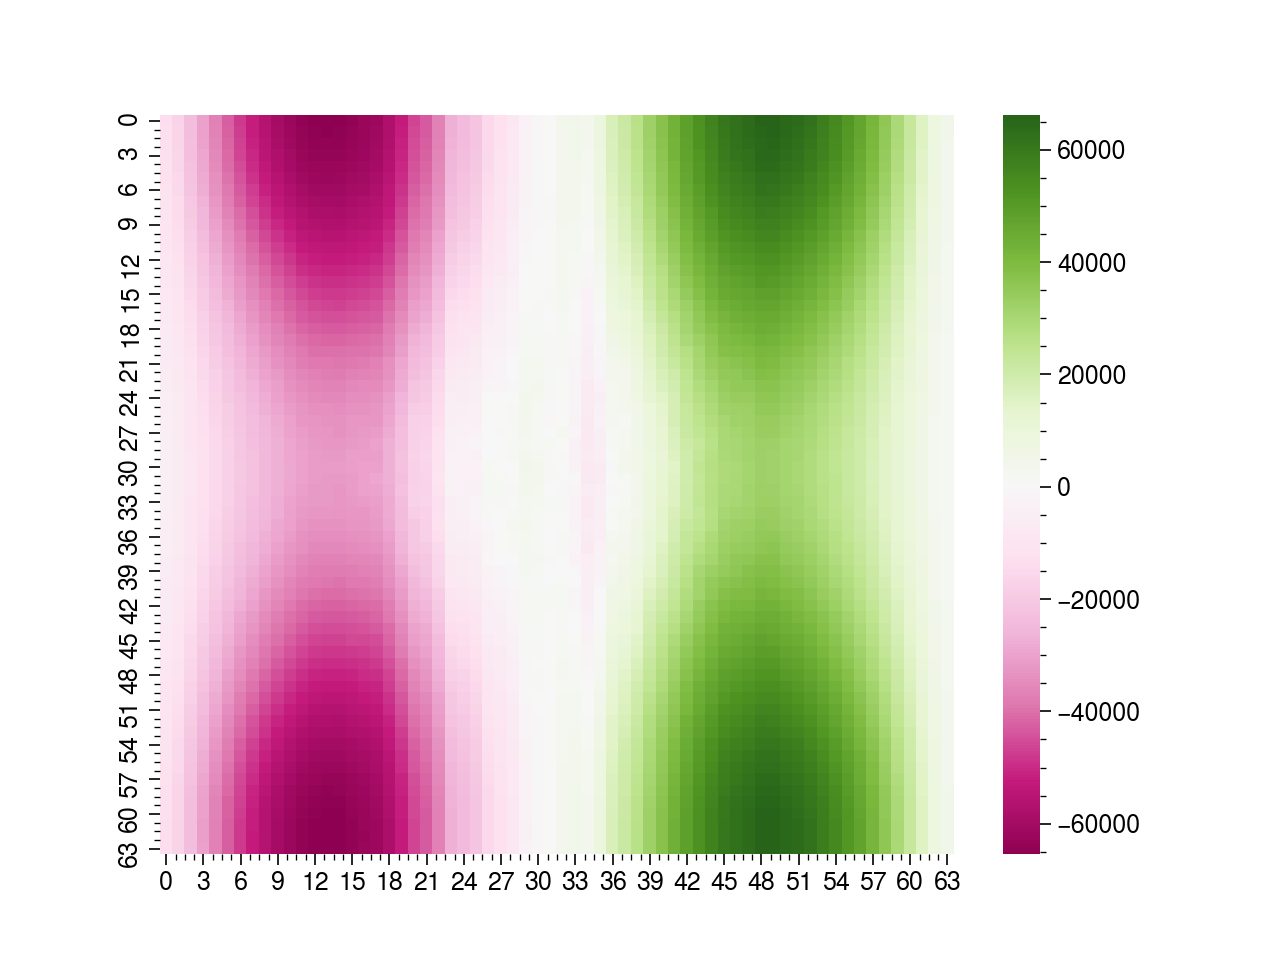

In [30]:
Ex, Ey = grid.compute_gradient(phi)
sns.heatmap(Ex.T, cmap='PiYG');

### Particle mover 

All we need to do in this step is integrate the equations of motion. There are lots of schemes to do this, but one common method is [leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration) in which the position and velocity are integrated out of phase as follows:

$$ m\left(\frac{\mathbf{v}_{i+1/2} - \mathbf{v}_{i-1/2}}{\Delta t}\right) = \mathbf{F}(\mathbf{x}_i),$$

$$ \frac{\mathbf{x}_{i+1} - \mathbf{x}_i}{\Delta t} = \mathbf{v}_{i+1/2}$$

This is a symplectic integrator, which means it will conserve energy. Also note that a different scheme must be used when magnetic fields are present. Let's implement this and test it on a simple harmonic oscillator.

In [166]:
class Simulation:
    def __init__(self, x0, v0, dt, force, kwargs={}):
        self.t = 0.
        self.dt = dt
        self.x = x0
        self.v = v0
        self.t_hist = []
        self.x_hist = []
        self.v_hist = []
        self.mass = 1.
        self.force = force
        self.kwargs = kwargs
        
    def store(self):
        self.t_hist.append(self.t)
        self.x_hist.append(self.x)
        self.v_hist.append(self.v)
        
    def get_force(self):
        return self.force(self.x, self.v, self.t, **self.kwargs)
        
    def initialize(self):
        self.step_velocity(-self.dt/2)
        self.store()
    
    def step_position(self, dt):
        self.x += self.v * dt
        
    def step_velocity(self, dt):
        self.v += (self.get_force() / self.mass) * dt
        
    def step(self):
        self.step_velocity(self.dt)
        self.step_position(self.dt)
        self.t += self.dt
        self.store()
        
    def run(self, nsteps=1):
        for _ in range(nsteps):
            self.step()

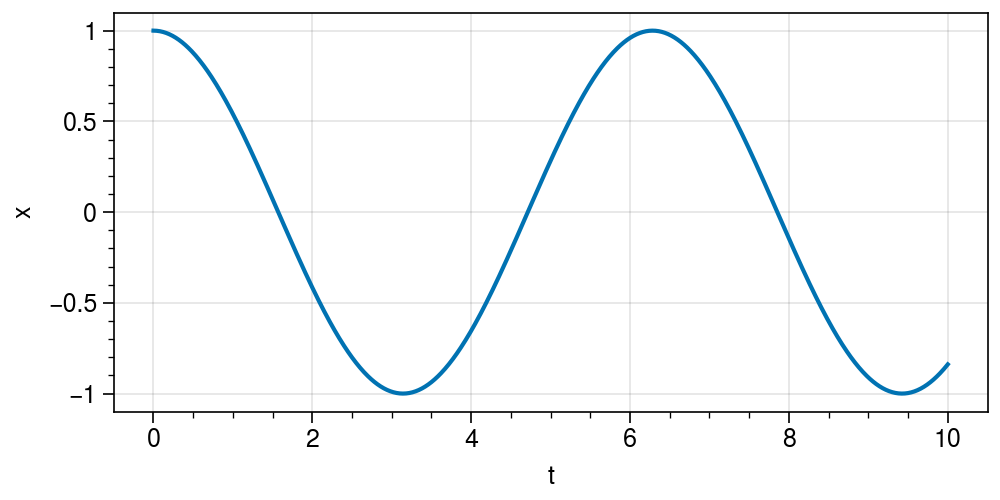

In [184]:
# Initial conditions
x0 = 1.
v0 = 0.
dt = 0.01

# Force function
def force(x, v, t, omega2=1.):
    F = -omega2 * x
    return F

sim = Simulation(x0, v0, dt, force)
sim.initialize()
sim.run(nsteps=int(10/dt))
t = sim.t_hist
x = sim.x_hist
v = sim.v_hist

fig, ax = plot.subplots(figsize=(5, 2.5))
ax.plot(t, x);
ax.format(xlabel='t', ylabel='x')

## Putting it all together

Now we can implement the full simulation loop. While $s < s_{max}$ we: 
1. Compute the charge density on the grid.
2. Find the electric potential on the grid.
3. Interpolate the electric field at the particle positions.
3. Update the particle positions.

### KV distribution 

### Gaussian distribution 